# Second order inchworm configuration and its contribution to the pseudo-particle self-energy

In [1]:
import Keldysh; kd = Keldysh
import KeldyshED; ked = KeldyshED; op = KeldyshED.Operators;

import QInchworm.ppgf

import QInchworm; cfg = QInchworm.configuration

import QInchworm.configuration: Expansion, InteractionPair
import QInchworm.configuration: Configuration, Node, InchNode, NodePair, NodePairs

import QInchworm.qmc_integrate: qmc_time_ordered_integral

import Sobol: SobolSeq
import LinearAlgebra: norm

┌ Info: Precompiling QInchworm [c1b6c5a0-2f71-4f50-a75d-692762eff855]
└ @ Base loading.jl:1423
┌ Warning: Package QInchworm does not have Test in its dependencies:
│ - If you have QInchworm checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with QInchworm
└ Loading Test into QInchworm from project dependency, future warnings for QInchworm are suppressed.


## Single correlated atom coupled to a bath level

System parameters

In [2]:
β = 10.;         # Inverse temperature
U = 1.0;         # Coulomb interaction
μ = U/2 + 0.3;   # Chemical potential
B = 0.1;         # Magnetic field
#ϵ = [-0.1, +0.1] # Bath energy levels
ϵ = [-1.0, +1.0] # Bath energy levels
V = 1.0;         # Hopping

Discretization

In [33]:
nt = 2;
ntau = 3;
#ntau = 1001;
#ntau = 5001;
tmax = 1.0;

Exact Diagonalization

In [34]:
H = -μ * (op.n(0, "up") + op.n(0, "dn")) + U * op.n(0, "up") * op.n(0, "dn") + B * (op.n(0, "up") - op.n(0, "dn"));
soi = ked.Hilbert.SetOfIndices([[0, "up"], [0, "dn"]]);
ed = ked.EDCore(H, soi);
ρ = ked.density_matrix(ed, β);

3-branch time contour

In [35]:
contour = kd.twist(kd.FullContour(tmax=tmax, β=β));
grid = kd.FullTimeGrid(contour, nt, ntau);

Hybridization function

In [36]:
dos = kd.DeltaDOS(ϵ, V^2 * ones(length(ϵ)))
Δ = kd.FullTimeGF(dos, grid);

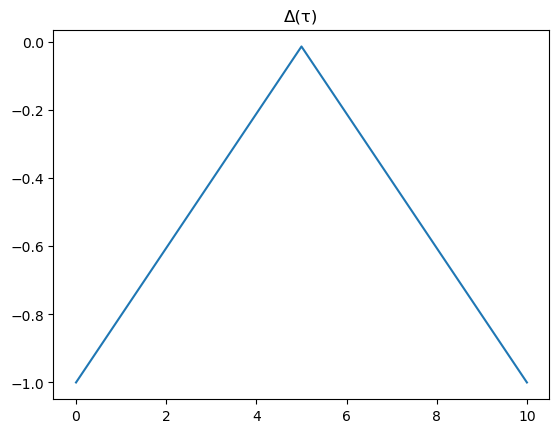

In [37]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

tau = Array(LinRange(0, β, 101))

b = contour[kd.imaginary_branch]
t0 = b(tau[1])
times = [ b(t/β) for t in tau ]
vals = [ Δ(t, t0) for t in times ]

plt.title("Δ(τ)")
plt.plot(tau, imag.(vals), "-");

Pseudo Particle Strong Coupling Expansion

In [38]:
ip_up = InteractionPair(op.c_dag(0, "up"), op.c(0, "up"), Δ);
ip_dn = InteractionPair(op.c_dag(0, "dn"), op.c(0, "dn"), Δ);
ppsc_exp = Expansion(ed, grid, [ip_up, ip_dn]);

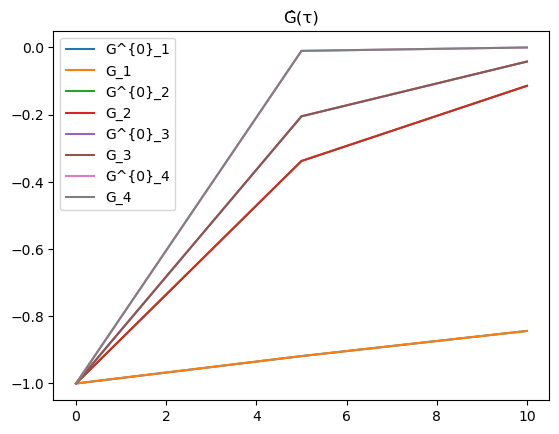

In [39]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

plt.title("Ĝ(τ)")
for (idx, G_s) in enumerate(ppsc_exp.P0)
    vals = [ G_s(t, t0) for t in times ]
    vals = vcat(vals...)    
    plt.plot(tau, imag.(vals), "-", label="G^{0}_$idx")

    vals = [ ppsc_exp.P[idx](t, t0) for t in times ]
    vals = vcat(vals...)    
    plt.plot(tau, imag.(vals), "-", label="G_$idx")
end

plt.legend(loc="best");

2nd order inchworm diagram on the imaginary branch

In [40]:
tau_grid = grid[kd.imaginary_branch]
τ_0, τ_β = tau_grid[1], tau_grid[end]

for t in tau_grid
    println(imag(t.bpoint.val))
end

τ_i = τ_0
τ_f = τ_β

τ_w_pos = 0.5 # Inchworm split time at 0.8β
#τ_w_pos = 0.8 # Inchworm split time at 0.8β
τ_w_idx = 1 + Int(τ_w_pos * (ntau - 1))
τ_w = tau_grid[τ_w_idx]
println(τ_w)

n_i = Node(τ_i.bpoint)
n_w = InchNode(τ_w.bpoint)
n_f = Node(τ_f.bpoint)

nodes = [n_f, n_w, n_i]
conf_0 = Configuration(nodes, NodePairs());
init_0 = zero(cfg.eval(ppsc_exp, conf_0));

0.0
-5.0
-10.0
Keldysh.TimeGridPoint(4, 2, Keldysh.BranchPoint(0.0 - 5.0im, 0.5, Keldysh.imaginary_branch))


Quasi Monte Carlo integration over a $d = 3$ domain

In [41]:
function second_order_diag_eval(τ)
    # Loop over spin indices of hybridization lines
    sum = deepcopy(init_0)
    for index1 = 1:2, index2 = 1:2
        # 4 arrangements of creation and annihilation operators
        conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
        sum += cfg.eval(ppsc_exp, conf)
        conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
        sum += cfg.eval(ppsc_exp, conf)
        conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
        sum += cfg.eval(ppsc_exp, conf)
        conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
        sum += cfg.eval(ppsc_exp, conf)
    end
    return sum
end

second_order_diag_eval (generic function with 1 method)

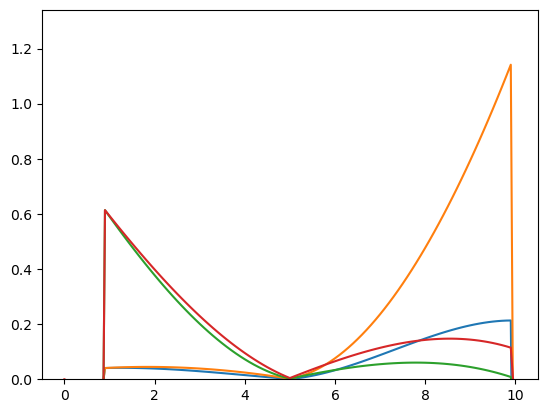

t1 = Keldysh.BranchPoint(0.0 - 0.8999999999999999im, 0.09, Keldysh.imaginary_branch)


(0.0, 1.341013183312797)

In [42]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

t1 = b(tau[10]/β)
println("t1 = $t1")

vals = [ second_order_diag_eval([b(t/β), t1, t0]) for t in tau ]
#println(vals)

for s in 1:4
    val_s = [ d[s][2] for d in vals ]
    val_s = vcat(val_s...)    
    #println(val_s)
    plt.plot(tau, imag.(val_s))
end

plt.ylim(bottom=0)

In [43]:
import MultiQuad: tplquad

func_sector(z, y, x, sector) = -imag(second_order_diag_eval([b(z/β), b(y/β), b(x/β)])[sector][2][1, 1])

tau_w = τ_w_pos*β

quad_res = [ tplquad((z,y,x) -> func_sector(z, y, x, s), 
        0, tau_w, x->x, x->tau_w, (x,y)->y, (x,y)->tau_w, rtol=1e-3, atol=1e-3) for s in 1:4]

error = [ s[2] for s in quad_res ]
integral = [ s[1] for s in quad_res ]

println("error = $error")
println("integral = $integral")

error = [0.0006290578851673931, 0.0008217614658239947, 0.0024954267168174164, 0.0025626969506611086]
integral = [-0.5420857649497705, -0.5420982242697353, -3.389633774645594, -3.3895344178050255]


# Delaunay triangulation and integration

In [44]:
points = Array{Float64, 2}(undef, 3, 0)

tau_vals = [-imag(t.bpoint.val) for t in tau_grid]
for i = 1:τ_w_idx
    for j = i:τ_w_idx
        for k = j:τ_w_idx
            points = cat(points, [tau_vals[i], tau_vals[j], tau_vals[k]]; dims=2)
        end
    end
end
points'

4×3 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.0  -0.0  -0.0
 -0.0  -0.0   5.0
 -0.0   5.0   5.0
  5.0   5.0   5.0

In [45]:
import PyCall as py;
sp = py.pyimport("scipy.spatial");

dl = sp.Delaunay(points', furthest_site=false);

simplices = py.py"$dl.simplices"

1×4 Matrix{Int32}:
 1  2  3  0

In [97]:
qp = py.pyimport("quadpy");
np = py.pyimport("numpy");


#scalar_integrand(x) = imag(second_order_diag_eval([b(x[1]), b(x[2]), b(x[3])])[3][2][1, 1])
scalar_integrand(x, sector) = func_sector(x[1], x[2], x[3], sector)

function integrand(x, sector)
    vals = []
    for i = 1:size(x, 2)
        push!(vals, scalar_integrand(x[:, i], sector))
    end
    vals
end

function do_integration(order)
    calc = qp.t3.get_good_scheme(order);

    val = [0., 0., 0., 0.]
    for i = 1:size(dl.simplices, 1)
        vidx = dl.simplices[i, :]
        tetra = Array{Float64}(Base.undef, 3, 0)
        for j = vidx
            tetra = cat(tetra, points[:, 1+j]; dims=2)
        end
        res = [ calc.integrate(x -> integrand(x, s), np.array(tetra')) for s in [1, 2, 3, 4] ]
        val += res
        #println(tetra, res)
        #println(res)
        #if res == NaN
        #    println(tetra)
        #end
    end
    return val
end

println()
println("integral = $integral")

if false
    orders = 2:1:10
    res = Array{Float64, 2}(undef, 0, 4)
    for order = orders
        println("order = $order")
        val = do_integration(order)
        println("val      = $val")
        if length(res) > 0
            diff = val - res[end, :]
            println("diff     = $diff")
        end
        res = cat(res, val'; dims=1)
    end

    println(res)
    println(size(res))

    errors = abs.(res[1:end-1, :] .- res[end, :]')
    println(errors)

    plt.semilogy(orders[2:end], errors)
    plt.xlabel("integrator order")
    plt.ylabel("pairwise difference")
    plt.savefig("figure_delaunay_integration_convergence.pdf")

end

val = do_integration(5)
println("val      = $val")

#using Test
#@test val ≈ integral


integral = [-0.5420857649497705, -0.5420982242697353, -3.389633774645594, -3.3895344178050255]
val      = [-0.5420546393194652, -0.5420546393194652, -3.389680488089975, -3.389680488089975]


## Numerical experiments

In [ ]:
function do_2nd_order_inchworm_diagram(τ_qmc, N, seq)
    qmc_time_ordered_integral(3, contour,
                              τ_i.bpoint, τ_w.bpoint,
                              init = deepcopy(init_0),
                              seq = seq, τ = τ_qmc, N = N) do τ
        # Loop over spin indices of hybridization lines
        sum = deepcopy(init_0)
        for index1 = 1:2, index2 = 1:2
            # 4 arrangements of creation and annihilation operators
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
            sum += cfg.eval(ppsc_exp, conf)
        end
        sum
    end
end

In [ ]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

# Scan a range of sample numbers N using incremental evaluation of the integral
function scan_N_range(τ_qmc, N_step::Int, N_points::Int)
    println("τ_qmc = $τ_qmc")
    N_list = zeros(Int, N_points)
    chunks = zeros(Complex{Float64}, 4, N_points)
    Threads.@threads for i = 1:N_points
        N = i * N_step
        N_list[i] = N
        
        seq = SobolSeq(3)
        seq = skip(seq, N_step * N_points) # Acclaimed better uniformity see Sobol.jl docs
        seq = skip(seq, N - N_step, exact=true)
        
        val = do_2nd_order_inchworm_diagram(τ_qmc, N_step, seq)
        chunks[:, i] = [val[s][2][1] for s = 1:4]
        
        println("N = $N, val = ", chunks[:, i])
    end
    results = cumsum(chunks, dims=2)
    for i = 1:N_points
        results[:, i] /= i
    end
    (N_list, results)
end

# Scan a range of sample numbers N without optimizations
function scan_N_range_unopt(τ_qmc, N_step::Int, N_points::Int)
    println("τ_qmc = $τ_qmc")
    N_list = collect(range(N_step, step=N_step, length=N_points))
    results = zeros(Complex{Float64}, 4, N_points)
    Threads.@threads for (i, N) in collect(enumerate(N_list))
        N_list[i] = N
        
        val = do_2nd_order_inchworm_diagram(τ_qmc, N, SobolSeq(3))
        
        results[:, i] = [val[s][2][1] for s=1:4]
        println("N = $N, res = ", results[:, i])
    end
    (N_list, results)
end

using HDF5
function h5_write_results(group_name, ref, τ_qmc, N_range, results, div)
    h5open("2nd_order_inchworm.h5", "cw") do file
        if group_name in keys(file)
            delete_object(file, group_name)
        end
        g = create_group(file, group_name)
        write(g, "ref", ref)
        write(g, "tau_qmc", τ_qmc)
        write(g, "N_range", collect(N_range))
        write(g, "results", results)
        write(g, "div", div)
    end
end

In [ ]:
Threads.nthreads()

In [ ]:
#τ_qmc = 4.0β
#τ_qmc = 2.0β
τ_qmc = 1.0β
#τ_qmc = 0.5β

N_step = 100000
N_points = 8 * 1000
#N_points = 24 * 10

#N_step = 10000
#N_points = 24 * 100

#N_step = 10000
#N_points = 2000

N_list, results = scan_N_range(τ_qmc, N_step, N_points);

## Check against the unoptimized version
#N_list_unopt, results_unopt = scan_N_range_unopt(τ_qmc, N_step, N_points)
#@assert N_list == N_list_unopt
#@assert isapprox(norm(results - results_unopt, Inf), 0, atol=1e-14)

In [ ]:
results[:, end]

In [ ]:
ref = val
println("res = $(real(results[:, end]))")
println("ref = $ref")
println("diff = $(abs.(real(results[:, end]) - ref))")

div = results - (ref .* ones(Float64, N_points)')

h5_write_results("tau_qmc_$τ_qmc", ref, τ_qmc, N_list, results, div)

for s=1:4
    plt.loglog(N_list, abs.(div[s, :]), label = "\$s=$s\$")
end

for i = -3:5
    plt.loglog(N_list, 10. .^i ./N_list, "-k", lw=0.5)
    plt.loglog(N_list, 10. .^(i-2) ./ sqrt.(N_list), ":k", lw=0.5)
end

plt.xlabel(raw"$N$")
plt.ylabel(raw"$|P - P_{ref}|$")
plt.xlim(N_list[1], N_list[end])
plt.ylim(minimum(abs.(div)), maximum(abs.(div)))
plt.legend(title="\$\\tau_{qmc} = $τ_qmc\$")

#plt.text(1e5, 1e-7, "\$\\tau_{qmc} = $τ_qmc\$")

plt.savefig("2nd_order_inchworm_tau$τ_qmc.pdf")

In [ ]:
# Test a single value of the integrand

τ = [tau_grid[end-20].bpoint, tau_grid[end-30].bpoint, tau_grid[end-40].bpoint]
@show τ

@show Δ(n_f.time, τ[2])
@show Δ(τ[2], n_f.time)
@show Δ(τ[1], τ[3])
@show Δ(τ[3], τ[1])

s = deepcopy(init_0)   
for index1 = 1:2, index2 = 1:2
    # 4 arrangements of creation and annihilation operators
    conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
    @show v1 = cfg.eval(ppsc_exp, conf)
    s += v1
    conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
    @show v2 = cfg.eval(ppsc_exp, conf)
    s += v2
    conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
    @show v3 = cfg.eval(ppsc_exp, conf)
    s += v3
    conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
    @show v4 = cfg.eval(ppsc_exp, conf)
    s += v4
end
    
println(s)